In [ ]:
#Notebook for doing the actual classification

In [1]:
import warnings
warnings.filterwarnings("ignore")
from utils.dataset import AudioDataset, TextDataset, MultimodalDataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch import nn
import torch
from utils.model import LSTMnet_RnnAtten
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pandas as pd
from sklearn.svm import SVC

In [2]:
train_annotations = '..\\data\\MELD\\train_sent_emo.csv'
val_annotations = '..\\data\\\MELD\\dev_sent_emo.csv'
test_annotations = '..\\data\\MELD\\test_sent_emo.csv'

train_bert = '..\\text_only\\embeddings\\bert_embeddings'
val_bert = '..\\text_only\\embeddings\\bert_embeddings_val'
test_bert = '..\\text_only\\embeddings\\bert_embeddings_test'

train_audio = '.\\data\\MELD\\audio\\wav\\'

val_audio = '.\\data\\MELD\\audio\\wav_dev\\'

In [3]:
train = MultimodalDataset(train_annotations, train_audio, train_bert)
# val = MultimodalDataset(val_annotations, val_audio, val_bert)

train, val = train_test_split(train, test_size=0.2)
batch_size = 64

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle = True, drop_last=False)
val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=True, drop_last=False)
train_features, train_labels = next(iter(train_dataloader))


In [ ]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

In [101]:
def make_train_step(models, loss_fnc, optimizer):
    def train_step(X,Y, a):
        model0, model1 = models
        # set model to train mode
        model0.train()
        model1.train()
        # forward pass
        output_model0 = model0(X[:,:1611])
        output_model1 = model1(X[:,1611:])
        
        out_a = (1-a)*output_model0+a*output_model1
        predictions = torch.argmax(out_a, dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
        # compute loss
        loss = loss_fnc(out_a, Y)
        
        # compute gradients
        loss.backward()
        
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        
        return a, loss.item(), accuracy*100 , f1*100
    return train_step

In [102]:
def make_validate_fnc(models, loss_fnc):
    def validate(X,Y, a):
        with torch.no_grad():
            model0, model1 = models
            # set model to train mode
            model0.eval()
            model1.eval()
            # forward pass
            output_model0 = model0(X[:,:1611])
            output_model1 = model1(X[:,1611:])

            out_a = (1-a)*output_model0+a*output_model1
            predictions = torch.argmax((1-a)*output_model0+a*output_model1, dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
            # compute loss
            loss = loss_fnc(out_a, Y)
        return loss.item(), accuracy*100, predictions, f1*100
    return validate

In [103]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_audio = LSTMnet_RnnAtten(input_dim = 1611, hidden_dim=256, output_dim=7, num_layers=5).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model_audio.parameters()) )


Number of trainable params:  4415495


In [104]:
model_text = LSTMnet_RnnAtten(input_dim = 768, hidden_dim=128, output_dim=7, num_layers=3).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model_text.parameters()) )

Number of trainable params:  823815


In [105]:
model_audio.load_state_dict(torch.load("..\\audio\\best-model-parameters.pt"))
model_text.load_state_dict(torch.load("..\\text_only\\best-model-parameters.pt"))

FileNotFoundError: [Errno 2] No such file or directory: '..\\audio\\best-model-parameters.pt'

In [115]:
a = torch.rand(1, requires_grad=True, device=device)
OPTIMIZER = torch.optim.Adam([a],lr=0.0001, weight_decay=1e-3) #???
train_step = make_train_step((model_audio, model_text), loss_fnc, OPTIMIZER)
validate = make_validate_fnc((model_audio, model_text),loss_fnc)

val_accs = []
losses=[]
val_losses = []
f1s = []
val_f1s= []
epochs = 120 #
best_val_f1 = 0



for epoch in range(epochs):
    epoch_acc = 0
    epoch_loss = 0
    epoch_f1 = 0
    for idx, (features, labels) in enumerate(train_dataloader):
        X, Y = features, labels
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        a, loss, acc, f1= train_step(X_tensor,Y_tensor, a)
        epoch_acc += acc*len(features)/len(train)
        epoch_loss += loss*len(features)/len(train)
        epoch_f1 += f1*len(features)/len(train)
    for batch in val_dataloader:
        X_val, Y_val = batch
        break
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, _, val_f1= validate(X_val_tensor,Y_val_tensor, a)
    val_accs.append(val_acc.cpu())
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    f1s.append(epoch_f1)
    val_f1s.append(val_f1)
    if val_f1 > best_val_f1:
        best_epoch = epoch
        best_val_f1 = val_f1
        alpha = a
    
    print('')
    print(f"Epoch {epoch+1} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%  f1:{f1:.2f}%, val_f1:{val_f1:.2f}%")

tensor([0.2713], device='cuda:0', requires_grad=True)

Epoch 1 --> loss:1.7045, acc:43.89%, val_loss:1.6797, val_acc:51.56%  f1:30.44%, val_f1:35.08%
tensor([0.2832], device='cuda:0', requires_grad=True)

Epoch 2 --> loss:1.6976, acc:44.11%, val_loss:1.6785, val_acc:46.88%  f1:34.37%, val_f1:29.92%
tensor([0.2949], device='cuda:0', requires_grad=True)

Epoch 3 --> loss:1.6863, acc:44.56%, val_loss:1.6789, val_acc:42.19%  f1:34.59%, val_f1:25.03%
tensor([0.3066], device='cuda:0', requires_grad=True)

Epoch 4 --> loss:1.6818, acc:45.28%, val_loss:1.6533, val_acc:53.12%  f1:17.93%, val_f1:36.86%
tensor([0.3181], device='cuda:0', requires_grad=True)

Epoch 5 --> loss:1.6724, acc:45.56%, val_loss:1.6128, val_acc:56.25%  f1:38.43%, val_f1:40.50%
tensor([0.3293], device='cuda:0', requires_grad=True)

Epoch 6 --> loss:1.6620, acc:45.86%, val_loss:1.6667, val_acc:40.62%  f1:21.10%, val_f1:23.47%
tensor([0.3404], device='cuda:0', requires_grad=True)

Epoch 7 --> loss:1.6574, acc:46.08%, val_loss

alpha:  tensor([0.2150], device='cuda:0', requires_grad=True)


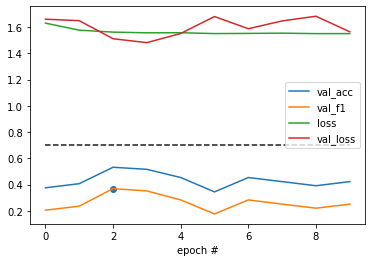

In [111]:
import matplotlib.pyplot as plt
x = range(epochs)

fig, ax = plt.subplots()
ax.set_xlabel('epoch #')
ax.set_ylabel('')
ax.plot(x,np.divide(val_accs,100), label='val_acc')
ax.plot(x,np.divide(val_f1s,100), label='val_f1')
ax.plot(x, losses, label='loss')
ax.plot(x, val_losses, label='val_loss')
ax.scatter(best_epoch, best_val_f1/100)
ax.plot(x, 0.7*np.ones(len(x)), '--', color=(0.1,0.1,0.1))
ax.legend()

print("alpha: ", alpha)



tensor([[1, 2, 1],
        [2, 2, 1],
        [2, 1, 1]])